# Detecting Human Body Keypoints

Book [Awesome AI: Make Art with Artificial Intelligence](http://kevinashley.com).

In addition, check this deep dive video course [AI in Sports with Python](http://activefitness.ai/ai-in-sports-with-python).



In [1]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:05<00:00, 43.7MB/s]


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [2]:
#@title Upload content image

import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os
%matplotlib inline

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
content_img = "content." + fn.split(".")[-1]
!mv -f $fn $content_img

img = Image.open(content_img)
(width, height) = img.size
content_img_max = max(width, height)
content_img_min = min(width, height)

# img = Image.open(content_img).resize((300, 300))
# display(Image.open(content_img).resize((300, 300)))

img = Image.open(content_img)
display(Image.open(content_img))

Output hidden; open in https://colab.research.google.com to view.

In [3]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([
                    # T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[133.2038, 163.4869, 140.9974, 183.3128],
         [ 62.9985,  58.6792, 224.0000, 142.3149],
         [202.0503,  57.2284, 219.1489, 108.8714],
         [ 96.7823,  76.8308, 224.0000, 126.3781]], grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1]),
 'scores': tensor([0.0947, 0.0803, 0.0524, 0.0511], grad_fn=<IndexBackward0>),
 'keypoints': tensor([[[135.0131, 168.0943,   1.0000],
          [135.5697, 167.8151,   1.0000],
          [134.7347, 167.8151,   1.0000],
          [138.0748, 165.0227,   1.0000],
          [134.1780, 166.4189,   1.0000],
          [139.7449, 168.3736,   1.0000],
          [136.1264, 168.0943,   1.0000],
          [140.0232, 170.8867,   1.0000],
          [133.8997, 166.6981,   1.0000],
          [139.4665, 167.8151,   1.0000],
          [138.6315, 167.5358,   1.0000],
          [138.9099, 168.6528,   1.0000],
          [135.8481, 168.0943,   1.0000],
          [139.1882, 174.7960,   1.0000],
          [135.2914, 173.1206,   1.0000],
    

In [ ]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)


In [ ]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [92, 24, 1], "left_eye": [93, 22, 1], "right_eye": [90, 22, 1], "left_ear": [93, 24, 1], "right_ear": [81, 24, 1], "left_shoulder": [96, 40, 1], "right_shoulder": [70, 40, 1], "left_elbow": [101, 61, 1], "right_elbow": [66, 64, 1], "left_wrist": [98, 70, 1], "right_wrist": [83, 72, 1], "left_hip": [92, 73, 1], "right_hip": [76, 74, 1], "left_knee": [106, 85, 1], "right_knee": [80, 86, 1], "left_ankle": [90, 121, 1], "right_ankle": [95, 122, 1]}, {"nose": [133, 25, 1], "left_eye": [135, 21, 1], "right_eye": [132, 23, 1], "left_ear": [143, 21, 1], "right_ear": [133, 25, 1], "left_shoulder": [158, 37, 1], "right_shoulder": [132, 41, 1], "left_elbow": [167, 58, 1], "right_elbow": [131, 66, 1], "left_wrist": [168, 80, 1], "right_wrist": [120, 55, 1], "left_hip": [157, 75, 1], "right_hip": [141, 73, 1], "left_knee": [141, 91, 1], "right_knee": [126, 85, 1], "left_ankle": [126, 127, 1], "right_ankle": [133, 118, 1]}]'

{'nose': [92, 24, 1], 'left_eye': [93, 22, 1], 'right_eye': [90, 22, 1], 'left_ear': [93, 24, 1], 'right_ear': [81, 24, 1], 'left_shoulder': [96, 40, 1], 'right_shoulder': [70, 40, 1], 'left_elbow': [101, 61, 1], 'right_elbow': [66, 64, 1], 'left_wrist': [98, 70, 1], 'right_wrist': [83, 72, 1], 'left_hip': [92, 73, 1], 'right_hip': [76, 74, 1], 'left_knee': [106, 85, 1], 'right_knee': [80, 86, 1], 'left_ankle': [90, 121, 1], 'right_ankle': [95, 122, 1]}
61


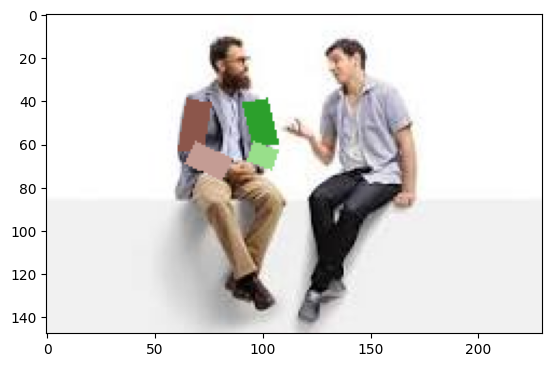

Number of raised hands:  1


In [ ]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)

def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)

def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    count = 0
    for i in range(len(data)):
      z = data[i]
      print(z)
      print(z['left_elbow'][1])
      colors = gen_colors()
      if(z['left_wrist'][1] > z['left_shoulder'][1] or z['right_wrist'][1] > z['right_shoulder'][1]):
        count = count + 1
        # drawline(draw, z, 'left_hip', 'nose', colors[0])
        # drawline(draw, z, 'left_hip', 'left_knee', colors[1])
        # drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
        # drawline(draw, z, 'left_shoulder', 'nose', colors[3])
        drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
        drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
        # drawline(draw, z, 'right_hip', 'nose', colors[6])
        # drawline(draw, z, 'right_hip', 'right_knee', colors[7])
        # drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
        # drawline(draw, z, 'right_shoulder', 'nose', colors[9])
        drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
        drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
      return img, count

result_image, result_count = draw_stickman(img, json_keypoints)
plt.imshow(result_image)
plt.show()
print("Number of raised hands: ", result_count)


In [1]:
pip install mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [4]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os
%matplotlib inline

Landmark: (99, 110)
Landmark: (99, 101)
Landmark: (99, 105)
Landmark: (96, 92)
Landmark: (99, 98)
Landmark: (98, 94)
Landmark: (98, 85)
Landmark: (75, 87)
Landmark: (97, 78)
Landmark: (97, 74)
Landmark: (96, 58)
Landmark: (99, 112)
Landmark: (99, 113)
Landmark: (99, 113)
Landmark: (100, 120)
Landmark: (100, 121)
Landmark: (100, 122)
Landmark: (100, 124)
Landmark: (100, 127)
Landmark: (99, 103)
Landmark: (96, 103)
Landmark: (63, 77)
Landmark: (84, 89)
Landmark: (81, 89)
Landmark: (78, 89)
Landmark: (74, 88)
Landmark: (87, 88)
Landmark: (80, 81)
Landmark: (83, 81)
Landmark: (77, 82)
Landmark: (75, 83)
Landmark: (71, 90)
Landmark: (88, 132)
Landmark: (74, 87)
Landmark: (61, 91)
Landmark: (68, 89)
Landmark: (82, 100)
Landmark: (94, 110)
Landmark: (95, 113)
Landmark: (89, 111)
Landmark: (86, 113)
Landmark: (91, 113)
Landmark: (88, 114)
Landmark: (83, 120)
Landmark: (96, 101)
Landmark: (96, 98)
Landmark: (70, 81)
Landmark: (89, 93)
Landmark: (88, 101)
Landmark: (88, 100)
Landmark: (71, 101)


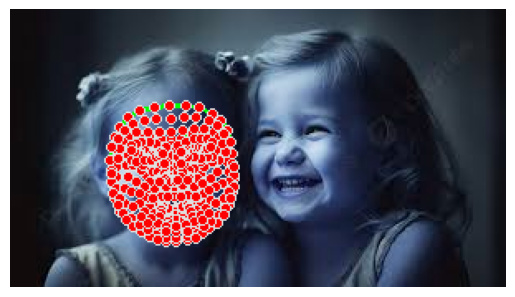

In [7]:
import cv2
import mediapipe as mp

# Initialize the MediaPipe Face Mesh solution
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Initialize the MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Load the image
image_path = '/content/two happy faces.jpg'
image = cv2.imread(image_path)
height, width, _ = image.shape

# Convert the image color from BGR to RGB
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image to get face landmarks
results = face_mesh.process(rgb_image)

# Custom Drawing Specifications
contour_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1)  # Green with thicker lines
landmark_spec = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=1)  # Red dots for landmarks

# Draw the face mesh annotations on the image
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            # connections=mp_face_mesh.FACEMESH_TESSELATION,
            # landmark_drawing_spec=None,
            # connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=landmark_spec,
            connection_drawing_spec=contour_spec
        )

        # To get keypoints as (x, y) coordinates:
        for landmark in face_landmarks.landmark:
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            print(f"Landmark: ({x}, {y})")

# Convert the image color from RGB to BGR (for OpenCV compatibility) and display

output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, image)
print(f"Image saved to {output_image_path}")

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Custom Drawing Specifications
contour_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)  # Green with thicker lines
landmark_spec = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1)  # Red dots for landmarks

# Draw the face mesh annotations on the image
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=landmark_spec,
            connection_drawing_spec=contour_spec
        )